# Customer Churn Analysis

In [1]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files("blastchar/telco-customer-churn",path='./Dataset',unzip=True)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pandas.core.computation.ops import isnumeric
from sympy.codegen.ast import continue_

In [3]:
import statsmodels.api as sta
import scipy as sp
import streamlit as st

In [169]:
churn_df = pd.read_csv(filepath_or_buffer="Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Let's quickly check if all elements are non-null.

In [171]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [172]:
def plot_col(col_names:str,color:str = "blue") -> plt.axes or str:
    plt.figure(figsize=(10,8));
    ax1 = (
        churn_df.
        value_counts(subset=col_names).
        plot(kind='bar',color=color,rot=0,fontsize=12)
    );
    # dir(ax1)
    ax1.set_xlabel(xlabel="");
    ax1.set_ylabel(ylabel="");
    ax1.set_title(label=f'{col_names} Counts',size=20,fontname='Arial',fontweight='bold');
    for sub_ax in ax1.patches:
        plt.text(x=sub_ax.get_x()+(sub_ax.get_width()/2),y=sub_ax.get_height()+50,s=str(sub_ax.get_height()),fontname='Arial',fontsize=15,ha='center',color='black',fontweight='bold');
    plt.tight_layout();
    plt.show()
    return ax1

# Exploring Categorical Data

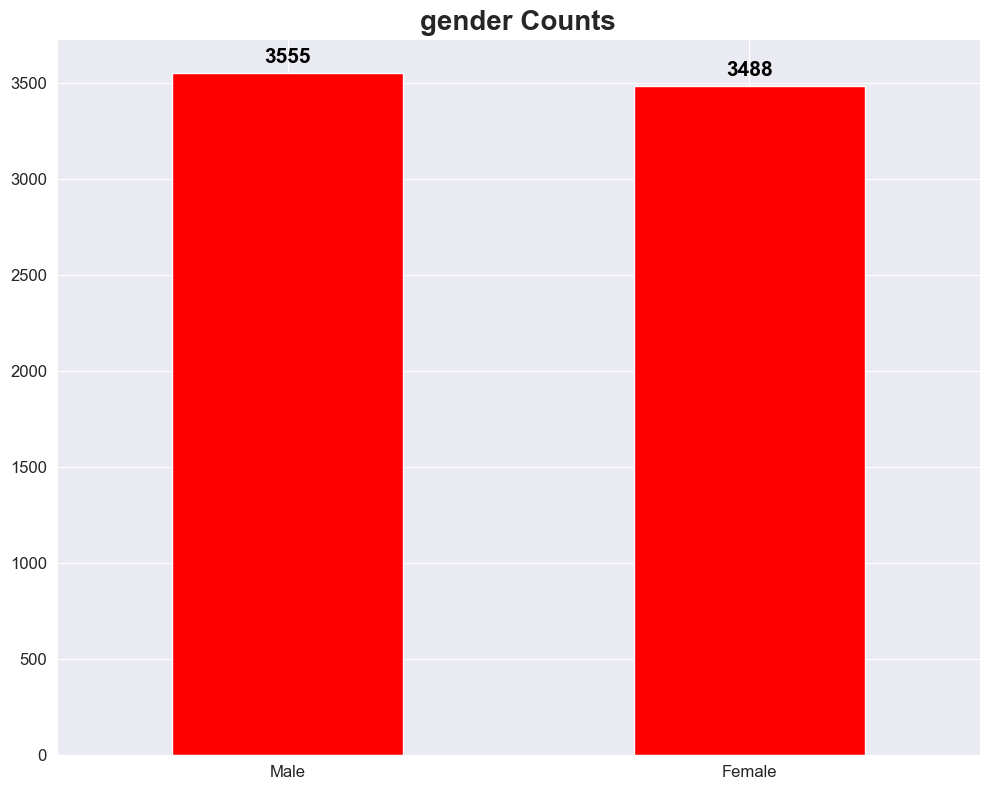

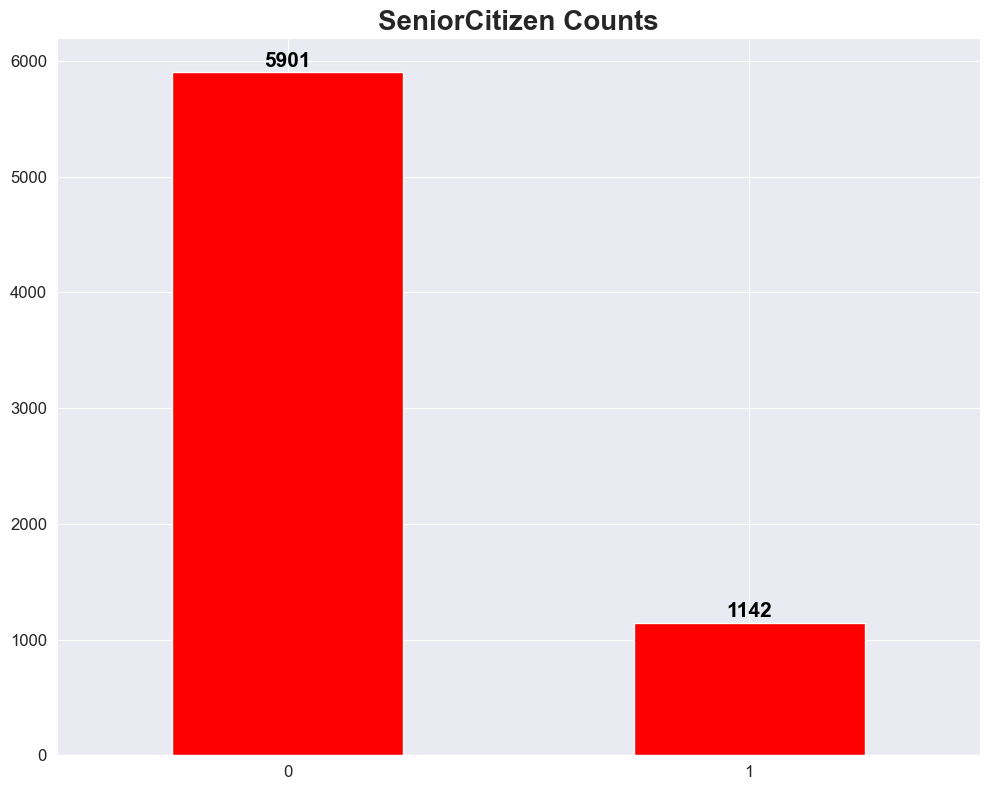

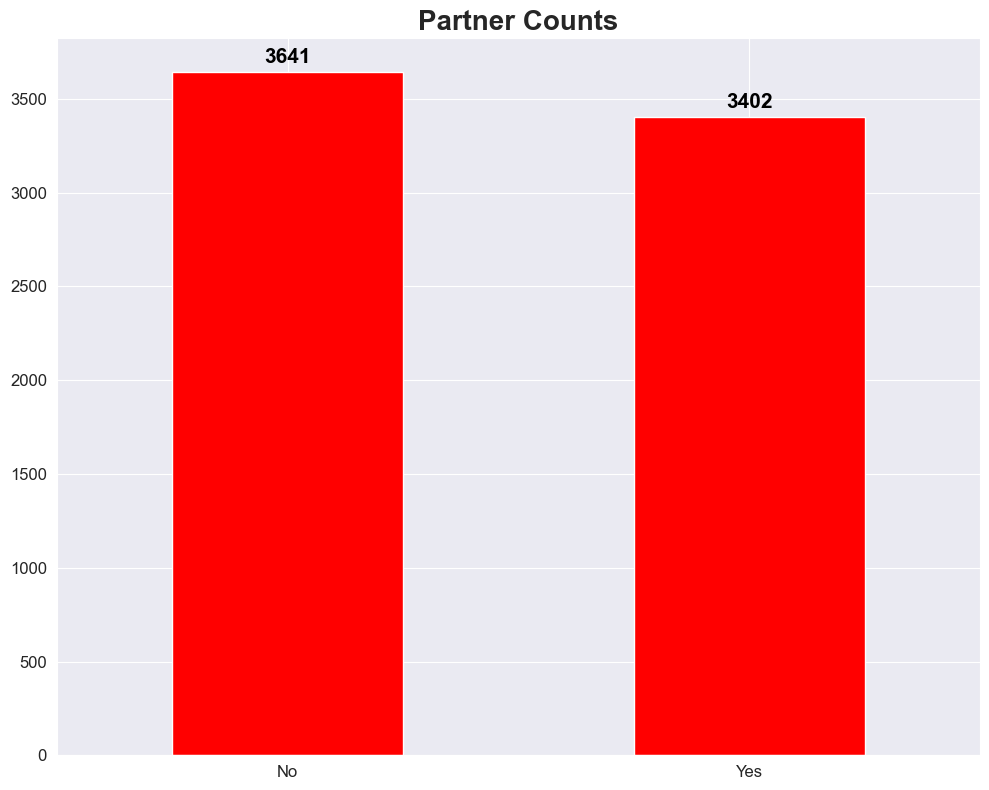

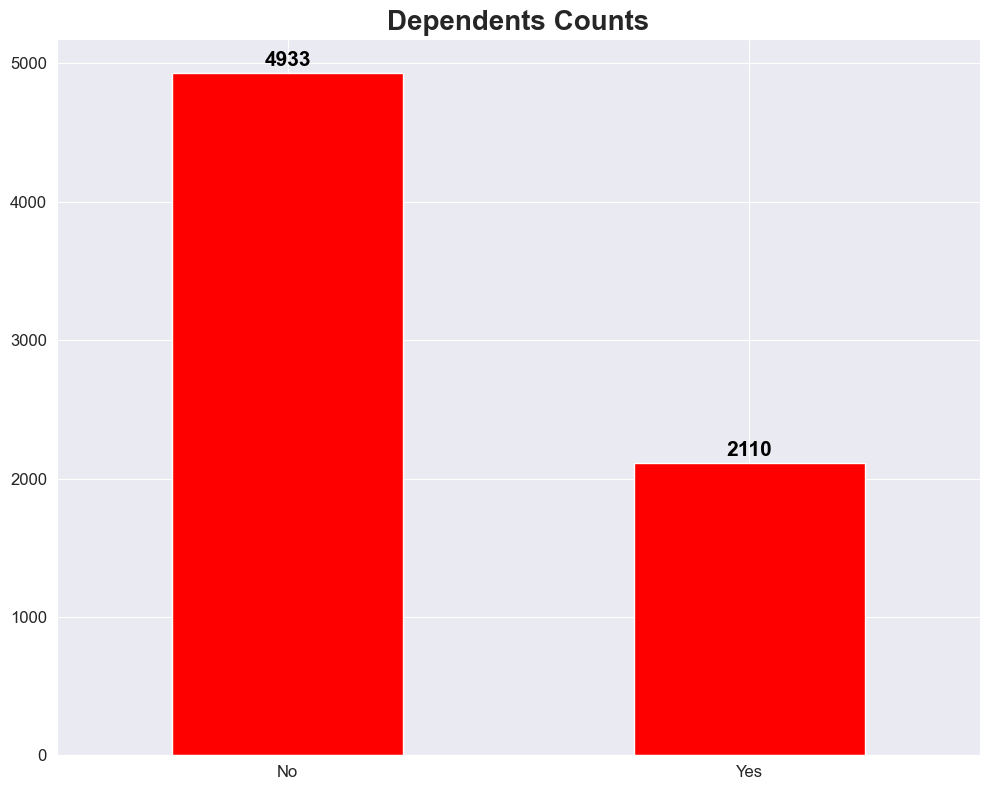

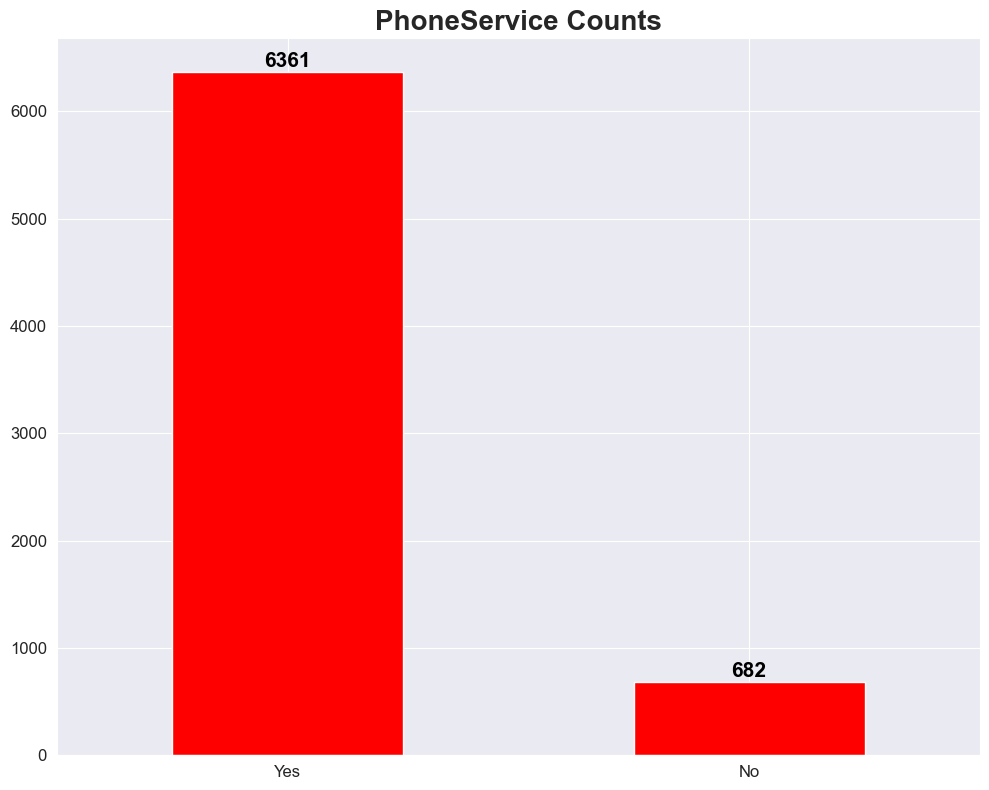

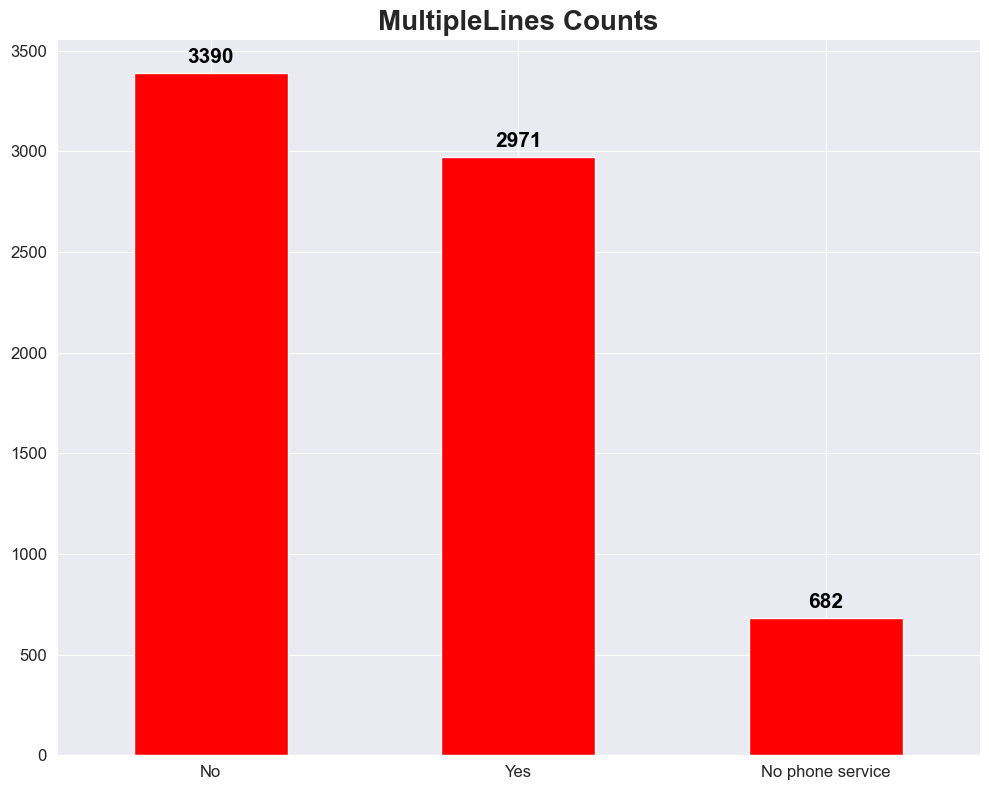

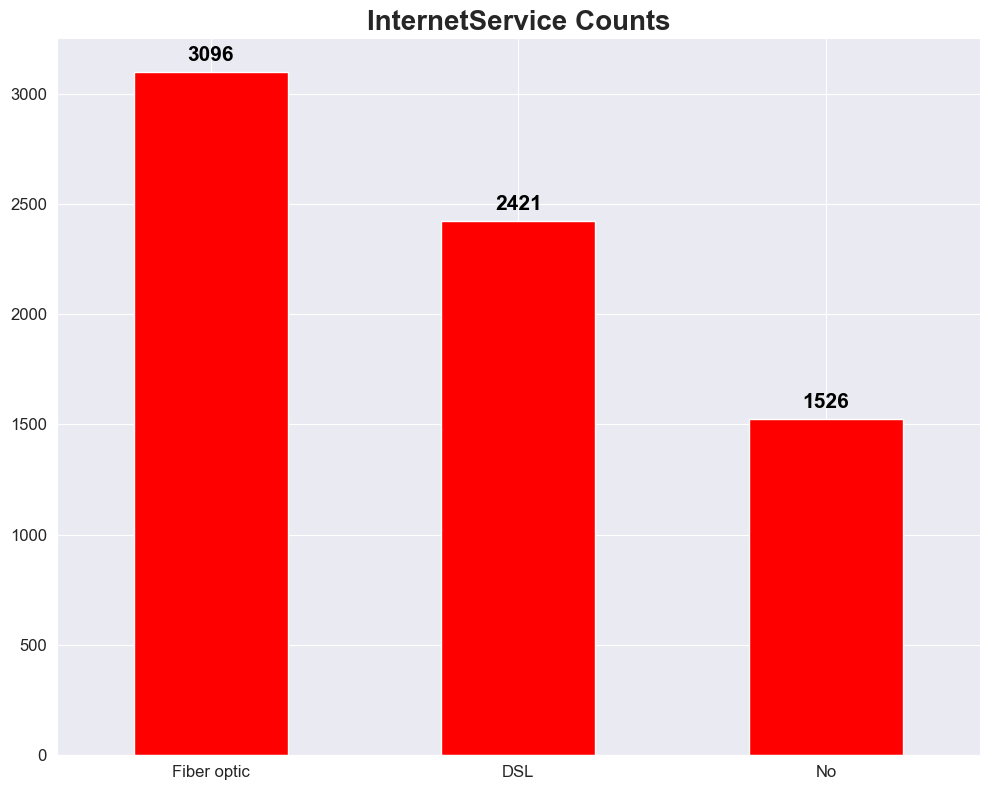

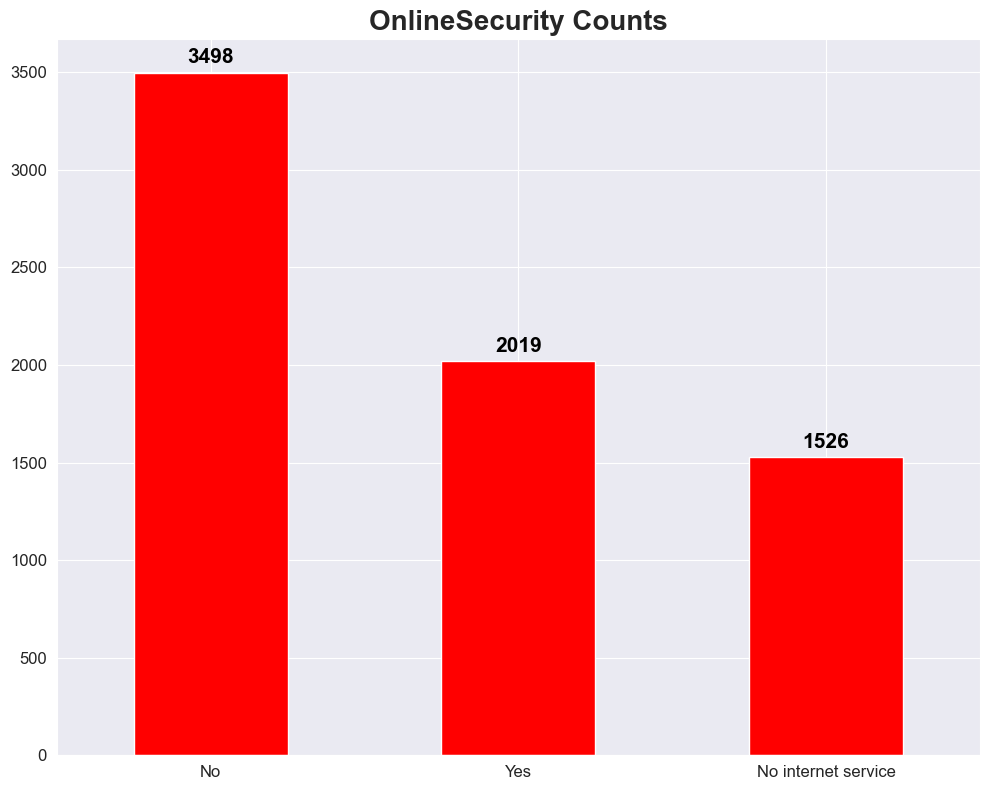

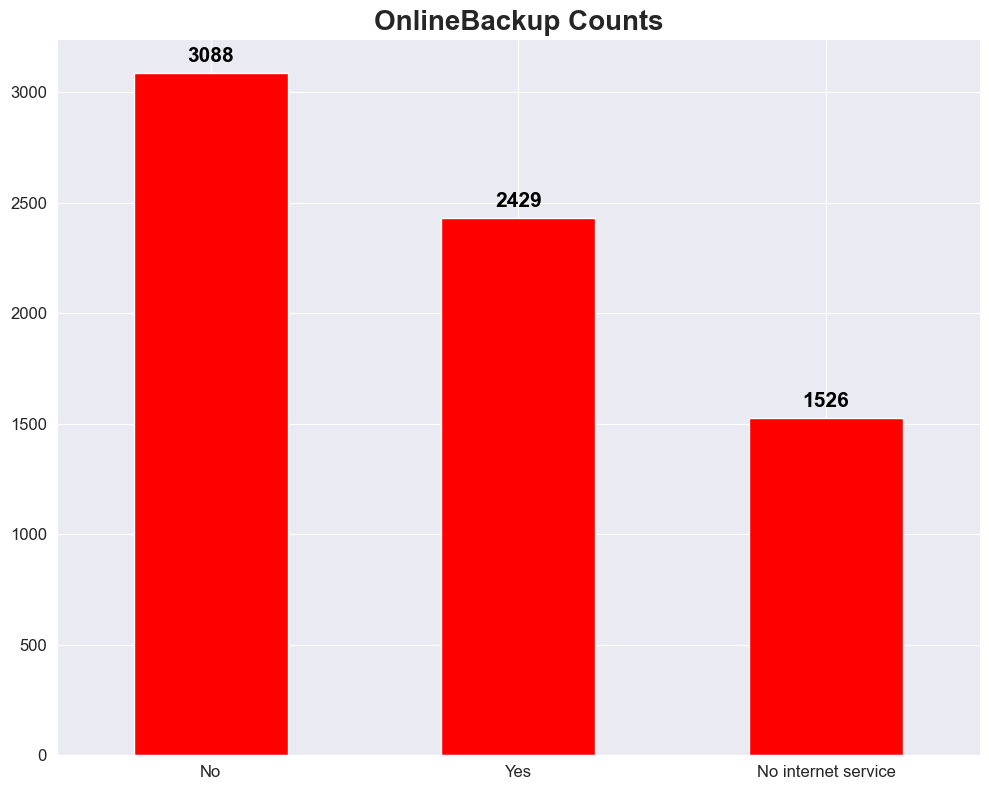

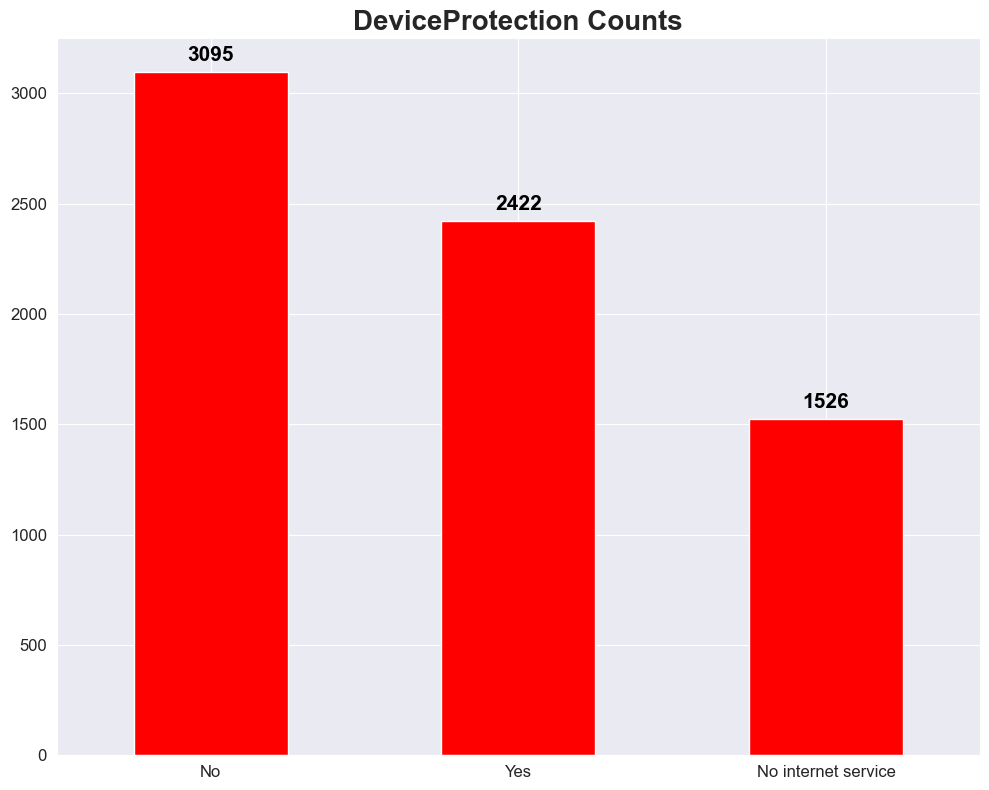

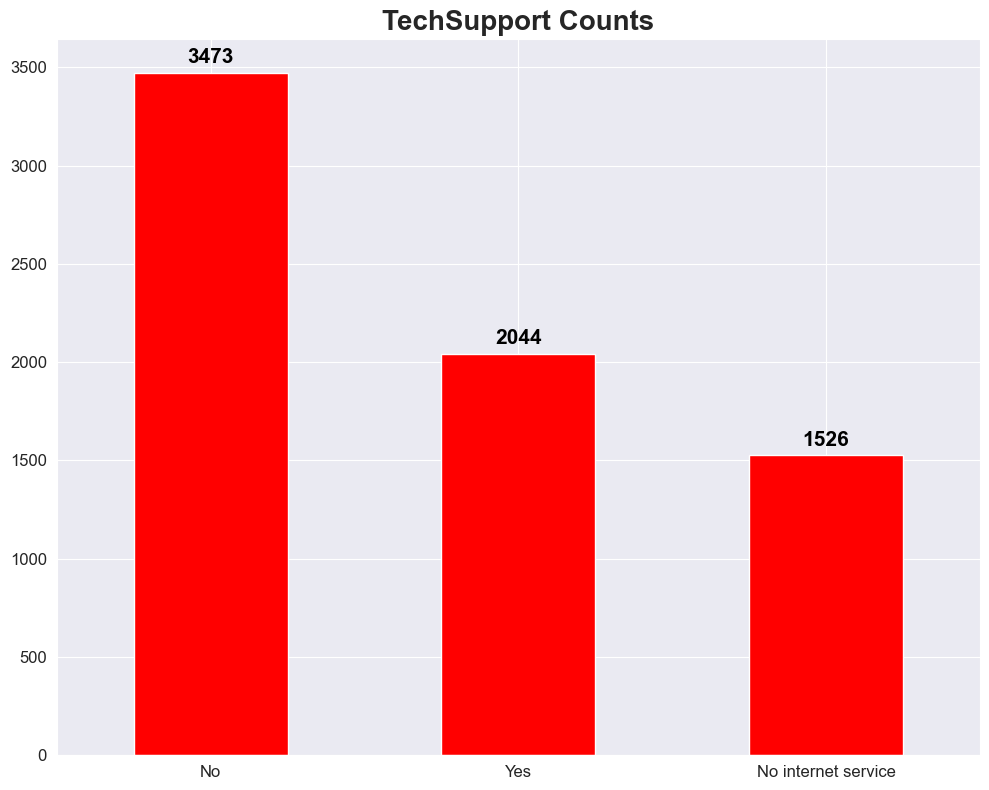

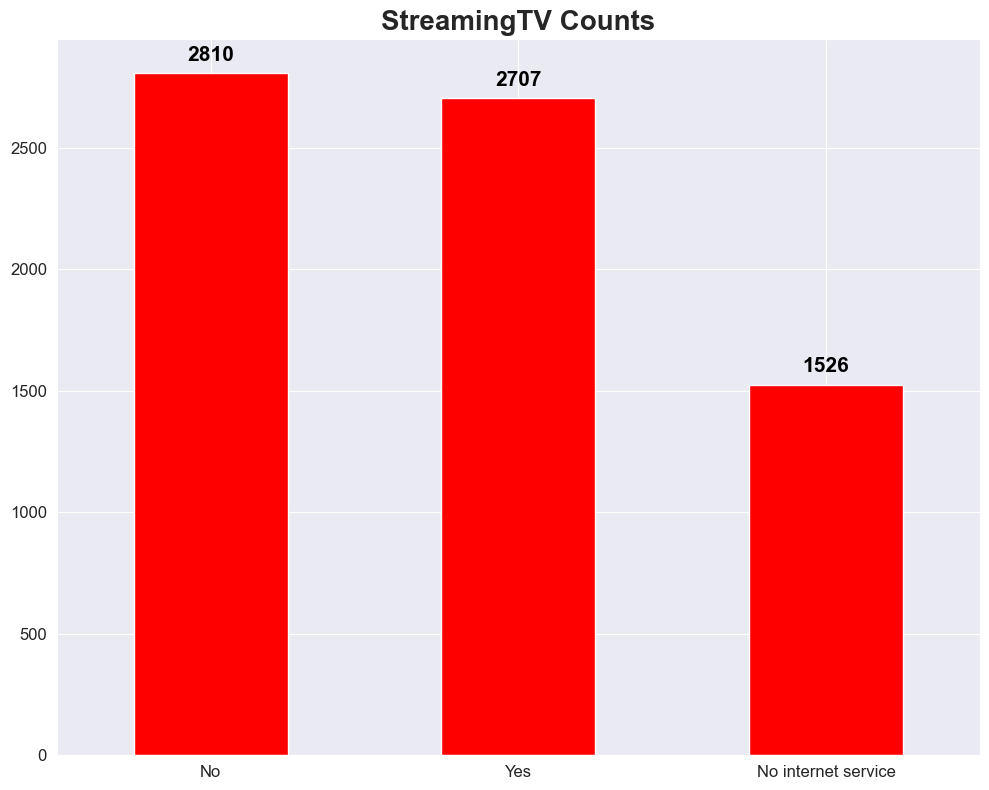

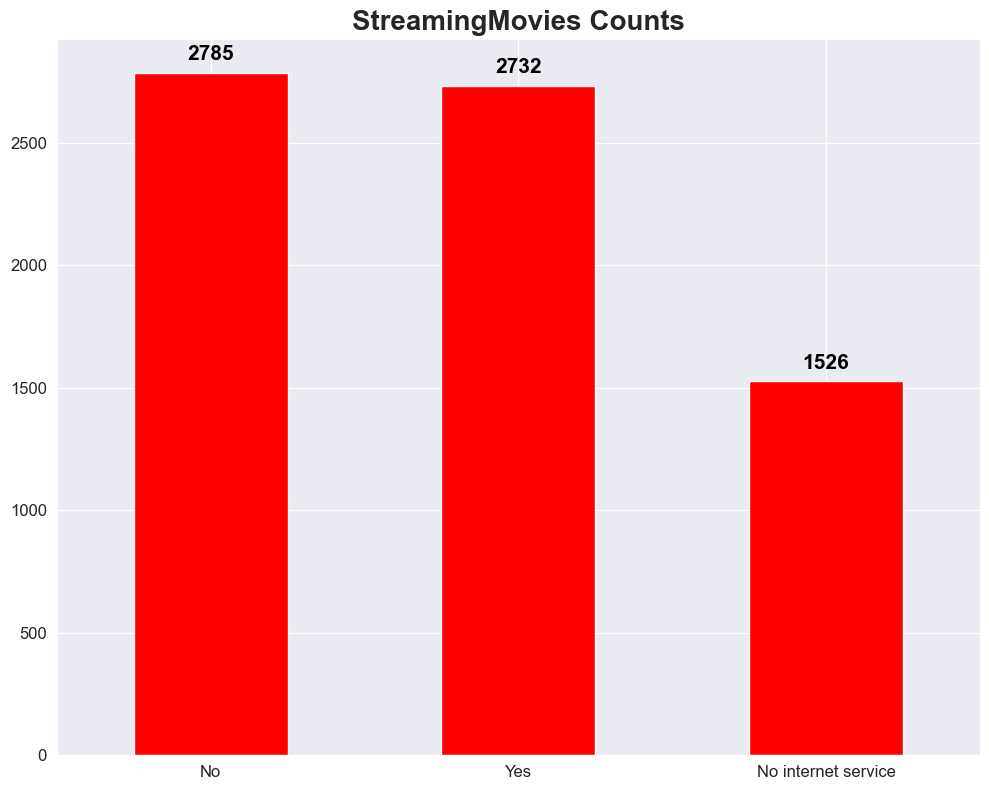

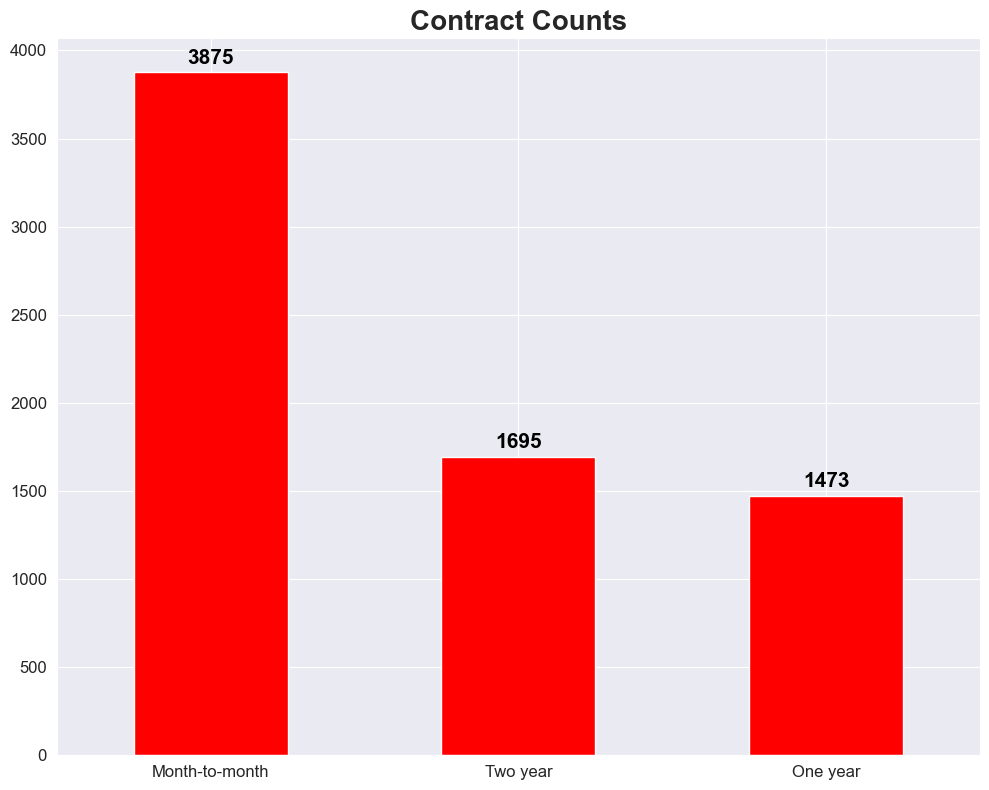

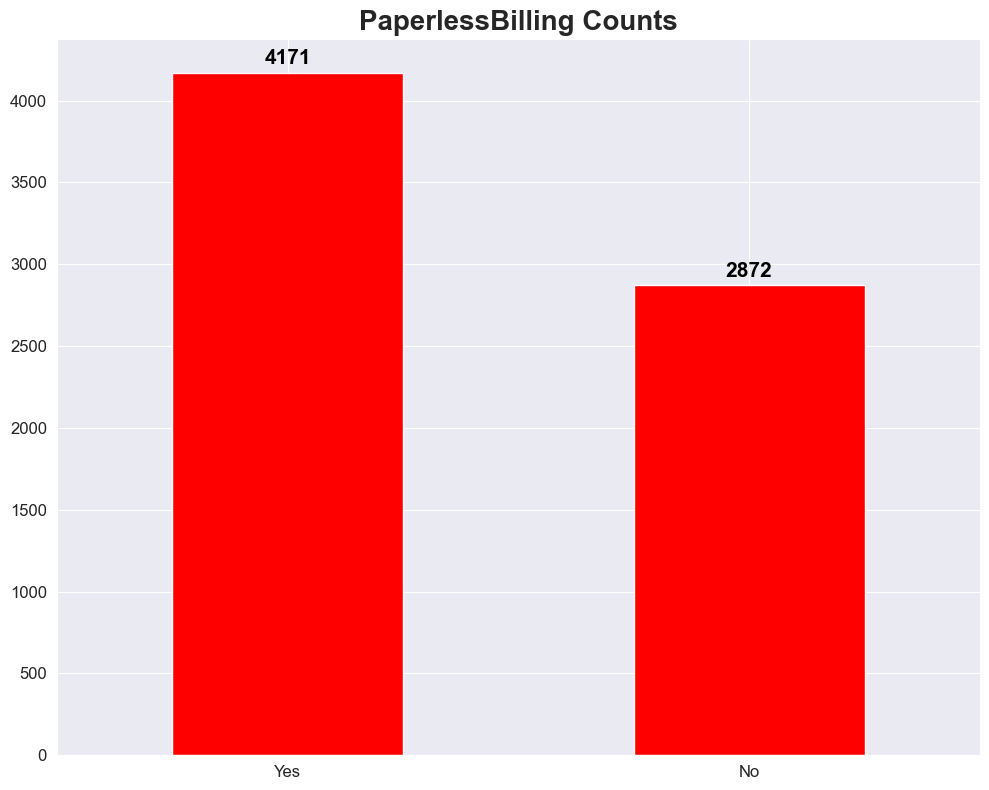

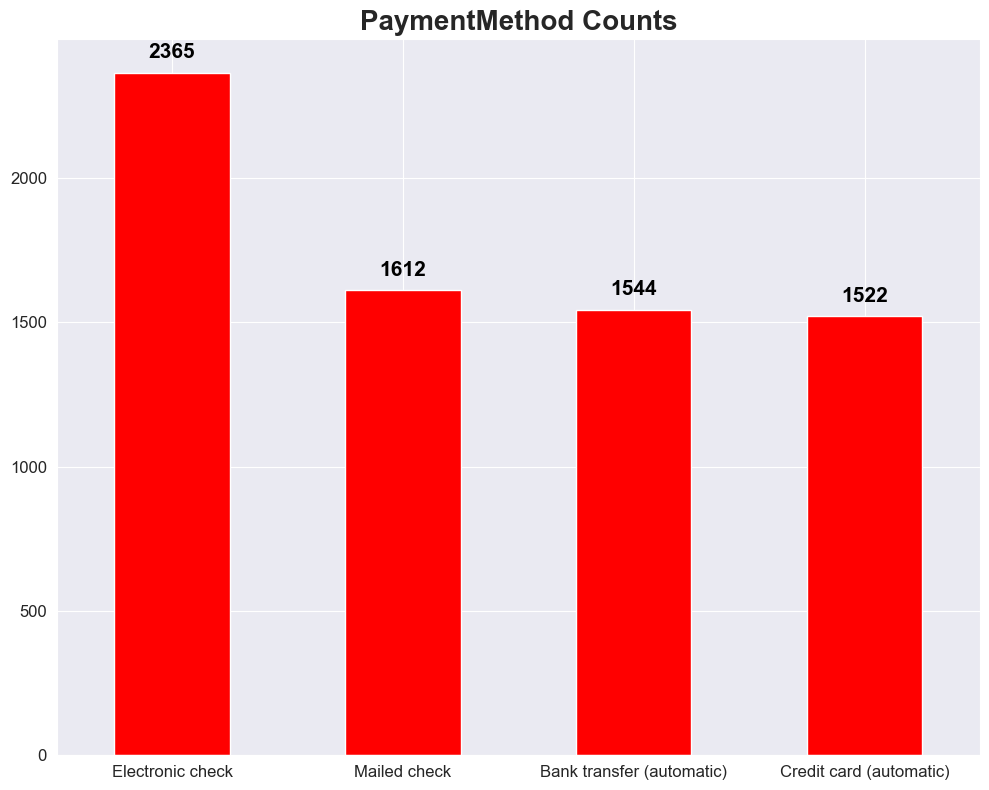

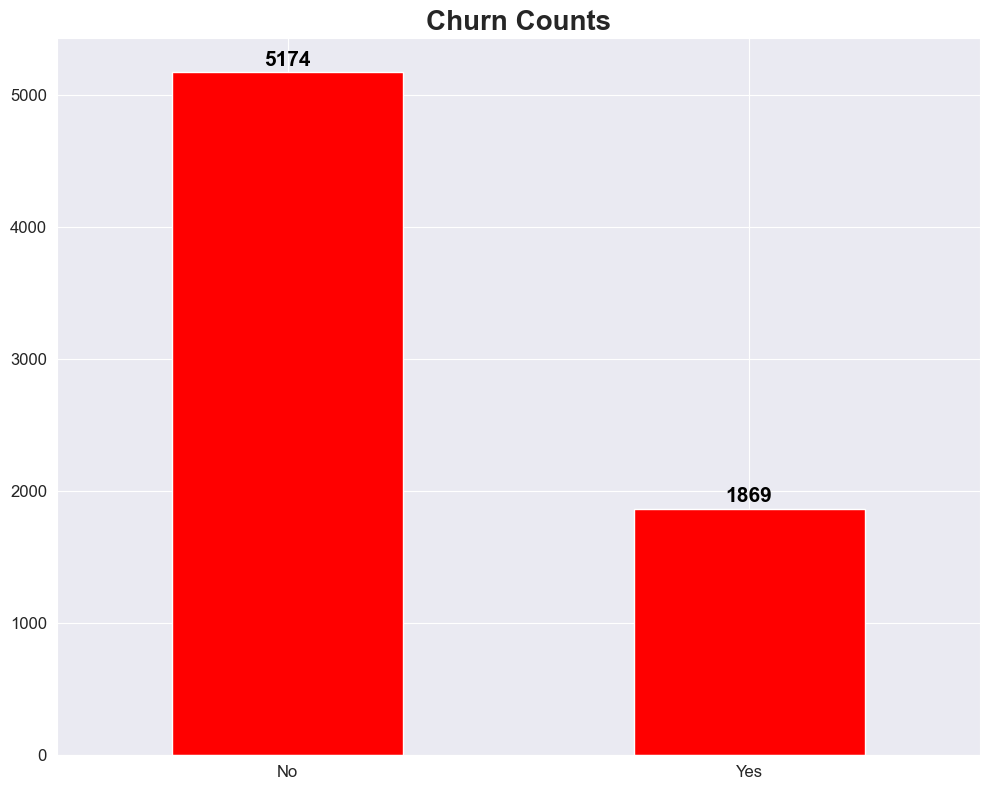

In [173]:
categorical_cond = (churn_df.nunique() < 5);
categorical_ls = churn_df.columns[categorical_cond] # Gets all columns that have 5 or lower values
for col in categorical_ls:
    plot_col(col,color = "red")

### __Results from plots above__:
1. There are approximately an equal amount of males and females in the dataset
2. There is a small, but sizeable amount of senior citizens
3. Slightly more than half the individuals in the dataset have a partner
4. About 70% of the individuals have dependents
5. About 73.5% of individuals in the dataset have left in the past month (i.e. churned)

# Exploring all Other Data Types

In [174]:
print("There are",len(categorical_ls),"categorical columns")

There are 17 categorical columns


We see that there are 17 categorical columns, which implies that there likely is only 4 non categorical columns.

In [175]:
non_categotrical_ls = churn_df.columns[~categorical_cond]
non_categotrical_ls.to_list()

['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [176]:
non_categotrical_churn = churn_df.loc[:,non_categotrical_ls];
non_categotrical_churn.head()

,customerID,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,1,29.85,29.85
1,5575-GNVDE,34,56.95,1889.5
2,3668-QPYBK,2,53.85,108.15
3,7795-CFOCW,45,42.30,1840.75
4,9237-HQITU,2,70.70,151.65


In [177]:
non_categotrical_churn.dtypes

customerID         object
tenure              int64
MonthlyCharges    float64
TotalCharges       object
dtype: object

Here, customerID and TotalCharges are object classes when they actually should be string and floats respectively. First let's convert customerID into a string

In [184]:
non_categotrical_churn['customerID']=non_categotrical_churn['customerID'].astype(str,errors='raise')
churn_df['customerID']=churn_df['customerID'].astype(str)

In [185]:
non_categotrical_churn.dtypes

customerID         object
tenure              int64
MonthlyCharges    float64
TotalCharges       object
dtype: object

While it might seem like the astype method did nothing, it is merely a Pandas quirk as there is no string type native to NumPy (remember that Pandas builds on NumPy).
Checking the type of individual values yields:

In [188]:
non_categotrical_churn['customerID'].apply(type).value_counts()

customerID
<class 'str'>    7043
Name: count, dtype: int64

Now, let's convert total charges to float64 values.

In [189]:
non_categotrical_churn['TotalCharges']=non_categotrical_churn['TotalCharges'].astype(np.float64)
churn_df['TotalCharges']=churn_df['TotalCharges'].astype(np.float64)

ValueError: could not convert string to float: ' '

Here, we get an error because there's empty string values in Total Charges.


Let's find out where in the dataset these empty values occur.

In [146]:
rows,cols = np.where(non_categotrical_churn == ' ')

In [191]:
non_categotrical_churn.loc[rows]

,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,
753,3115-CZMZD,0,20.25,
936,5709-LVOEQ,0,80.85,
1082,4367-NUYAO,0,25.75,
1340,1371-DWPAZ,0,56.05,
3331,7644-OMVMY,0,19.85,
3826,3213-VVOLG,0,25.35,
4380,2520-SGTTA,0,20.00,
5218,2923-ARZLG,0,19.70,
6670,4075-WKNIU,0,73.35,


As tenures are zero for these entries, it likely is the case that these are new members (< 1 month). In any case, let's check these rows from the bigger dataset as well.

In [192]:
churn_df.loc[rows]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


The fact that none of these individuals have churned (i.e. moved out), adds to the claim that these are individuals who have only been in TelCo service for less than a month.

With that said, the decision on whether we may use these entries will be answered in a little while.